### Example of the LSTM and GRU Model

- **Created On**: Dec 17 12:55 2022
- **Reference**: Awan, A.A. (2022). MasterCard Stock Price with LSTM and GRU. https://app.datacamp.com/workspace/w/94a70e98-585a-4dc4-b307-8a6627800ae2
- **Data Source** : Rahman, K. (2022). MasterCard Stock Data - Latest and Updated. https://www.kaggle.com/datasets/kalilurrahman/mastercard-stock-data-latest-and-updated

***

#### **Outset**

In [1]:
import os
# Show current working directory
os.getcwd()

'/home/waskito/project/gen/tmp/lstm_gru/model'

In [2]:
# Tensorflow flag
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
# Reuired libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn  as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Using keras v2.11.0 (depends on tensoflow v2.2 or higher)
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
from keras.utils import set_random_seed

set_random_seed(455)
np.random.seed(455)

#### **Data Analysis**

In [4]:
dataset = pd.read_csv(
    "../data/Mastercard_stock_history.csv", 
    index_col="Date", 
    parse_dates=["Date"]
    ).drop(["Dividends", "Stock Splits"], axis=1)

dataset.head()

,Open,High,Low,Close,Volume
Date,,,,,
2006-05-25,3.748967,4.283869,3.739664,4.279217,395343000
2006-05-26,4.307126,4.348058,4.103398,4.179680,103044000
2006-05-30,4.183400,4.184330,3.986184,4.093164,49898000
2006-05-31,4.125723,4.219679,4.125723,4.180608,30002000
2006-06-01,4.179678,4.474572,4.176887,4.419686,62344000


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3872 entries, 2006-05-25 to 2021-10-11
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3872 non-null   float64
 1   High    3872 non-null   float64
 2   Low     3872 non-null   float64
 3   Close   3872 non-null   float64
 4   Volume  3872 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 181.5 KB


In [6]:
dataset.describe()

,Open,High,Low,Close,Volume
count,3872.000000,3872.000000,3872.000000,3872.000000,3.872000e+03
mean,104.896814,105.956054,103.769349,104.882714,1.232250e+07
std,106.245511,107.303589,105.050064,106.168693,1.759665e+07
min,3.748967,4.102467,3.739664,4.083861,6.411000e+05
25%,22.347203,22.637997,22.034458,22.300391,3.529475e+06
50%,70.810079,71.375896,70.224002,70.856083,5.891750e+06
75%,147.688448,148.645373,146.822013,147.688438,1.319775e+07
max,392.653890,400.521479,389.747812,394.685730,3.953430e+08


In [7]:
dataset.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

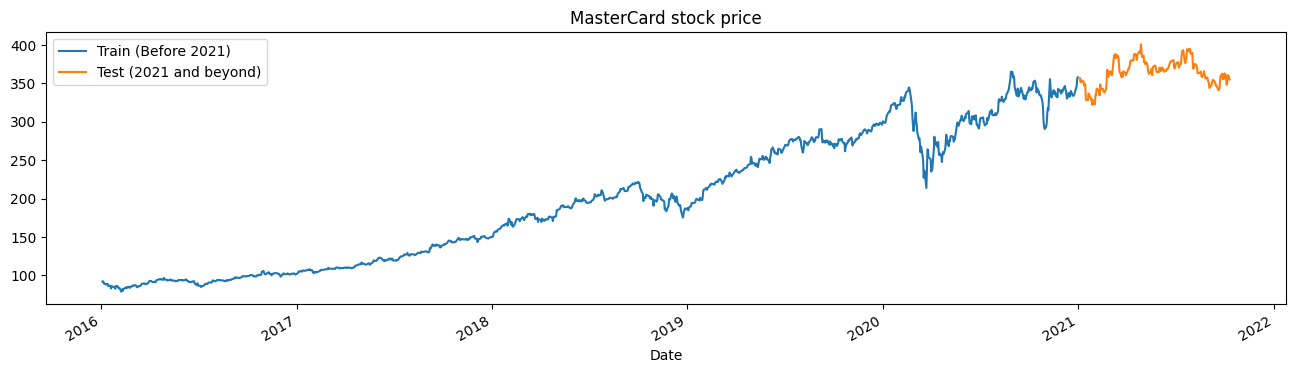

In [8]:
t_start = 2016
t_end = 2020

def train_test_plot(dataset, t_start, t_end):
    dataset.loc[f"{t_start}":f"{t_end}", "High"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{t_end+1}":, "High"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {t_end+1})", f"Test ({t_end+1} and beyond)"])
    plt.title("MasterCard stock price")
    plt.show()

train_test_plot(dataset, t_start, t_end)

#### **Data Preporcessing**

In [9]:
def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "High"].values
    test = dataset.loc[f"{tend+1}":, "High"].values
    return train, test

training_set, test_set = train_test_split(dataset, t_start, t_end)

**1. Scaling the training set**

In [10]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

**2. Split a univariate sequence into samples**

In [11]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence) - 1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 60
features = 1
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)

**3. Reshaping X_train for efficient modeling**

In [12]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)

#### **LSTM Model**

**1. Architecture**

In [13]:
# The LSTM architecture
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(n_steps, features)))
model_lstm.add(Dense(units=1))

# The GRU architecture
model_gru = Sequential()
# First GRU layer with Dropout regularisation
model_gru.add(GRU(units=125, activation="tanh", input_shape=(n_steps, features)))
model_gru.add(Dense(units=1))

**2. Compiling the RNN**

In [14]:
model_lstm.compile(optimizer="RMSprop", loss="mse")
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 125)               63500     
                                                                 
 dense (Dense)               (None, 1)                 126       
                                                                 
Total params: 63,626
Trainable params: 63,626
Non-trainable params: 0
_________________________________________________________________


In [15]:
model_gru.compile(optimizer="RMSprop", loss="mse")
model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 125)               48000     
                                                                 
 dense_1 (Dense)             (None, 1)                 126       
                                                                 
Total params: 48,126
Trainable params: 48,126
Non-trainable params: 0
_________________________________________________________________


#### **Training Model**

**1. LSTM**

In [16]:
model_lstm.fit(X_train, y_train, epochs=40, batch_size=32, verbose=1)

Epoch 1/40
38/38 [==============================] - 13s 161ms/step - loss: 0.0138
Epoch 2/40
38/38 [==============================] - 6s 159ms/step - loss: 0.0022
Epoch 3/40
38/38 [==============================] - 6s 156ms/step - loss: 0.0023
Epoch 4/40
38/38 [==============================] - 6s 152ms/step - loss: 0.0019
Epoch 5/40
38/38 [==============================] - 6s 151ms/step - loss: 0.0014
Epoch 6/40
38/38 [==============================] - 6s 159ms/step - loss: 0.0015
Epoch 7/40
38/38 [==============================] - 6s 155ms/step - loss: 9.5490e-04
Epoch 8/40
38/38 [==============================] - 6s 161ms/step - loss: 0.0013
Epoch 9/40
38/38 [==============================] - 6s 157ms/step - loss: 9.9275e-04
Epoch 10/40
38/38 [==============================] - 6s 154ms/step - loss: 0.0010
Epoch 11/40
38/38 [==============================] - 6s 155ms/step - loss: 7.9331e-04
Epoch 12/40
38/38 [==============================] - 6s 159ms/step - loss: 8.6259e-04
Epoch 13

**2. GRU**

In [17]:
model_gru.fit(X_train, y_train, epochs=40, batch_size=32, verbose=1)

Epoch 1/40
38/38 [==============================] - 11s 135ms/step - loss: 0.0188
Epoch 2/40
38/38 [==============================] - 6s 143ms/step - loss: 0.0016
Epoch 3/40
38/38 [==============================] - 6s 149ms/step - loss: 0.0015
Epoch 4/40
38/38 [==============================] - 5s 129ms/step - loss: 0.0013
Epoch 5/40
38/38 [==============================] - 5s 135ms/step - loss: 9.6061e-04
Epoch 6/40
38/38 [==============================] - 5s 138ms/step - loss: 0.0011
Epoch 7/40
38/38 [==============================] - 6s 149ms/step - loss: 6.8499e-04
Epoch 8/40
38/38 [==============================] - 5s 143ms/step - loss: 8.9177e-04
Epoch 9/40
38/38 [==============================] - 6s 160ms/step - loss: 7.3198e-04
Epoch 10/40
38/38 [==============================] - 6s 161ms/step - loss: 8.1340e-04
Epoch 11/40
38/38 [==============================] - 9s 227ms/step - loss: 6.7868e-04
Epoch 12/40
38/38 [==============================] - 13s 342ms/step - loss: 6.3763

#### **Testing Model**

In [18]:
dataset_total = dataset.loc[:,"High"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)

X_test, y_test = split_sequence(inputs, n_steps)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)

**1. LSTM**

In [19]:

lstm_predicted_stock_price = model_lstm.predict(X_test)
lstm_predicted_stock_price = sc.inverse_transform(lstm_predicted_stock_price)

7/7 [==============================] - 2s 79ms/step


**2. GRU**

In [20]:
gru_predicted_stock_price = model_gru.predict(X_test)
gru_predicted_stock_price = sc.inverse_transform(gru_predicted_stock_price)

7/7 [==============================] - 2s 54ms/step


#### **Evaluation**

In [21]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("MasterCard Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("MasterCard Stock Price")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

**1. LSTM**

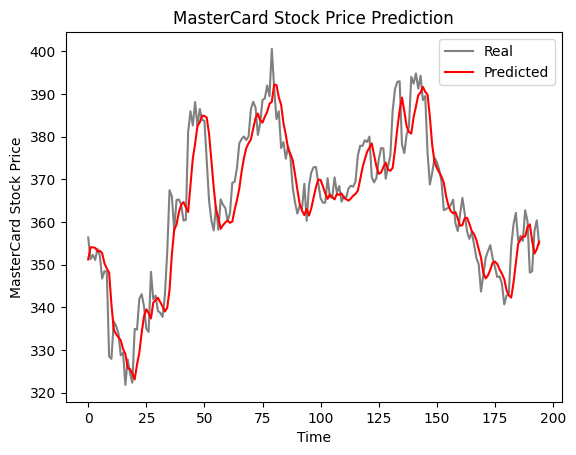

In [22]:
# Visualizing the results for LSTM
plot_predictions(test_set, lstm_predicted_stock_price)

In [23]:
# Root mean square erro of the LSTM
return_rmse(test_set,lstm_predicted_stock_price)

The root mean squared error is 6.61.


**2. GRU**

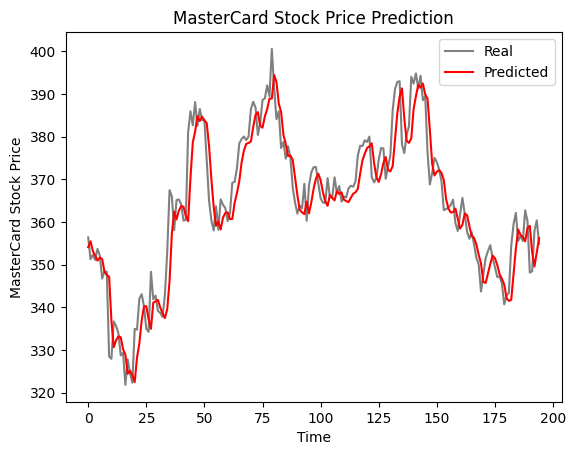

In [24]:
# Visualizing the results for GRU
plot_predictions(test_set, gru_predicted_stock_price)

In [26]:
# Root mean square erro of the GRU
return_rmse(test_set,gru_predicted_stock_price)

The root mean squared error is 6.03.
